### Step 1: Load the Libraies and Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from numpy.linalg import lstsq
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import LSTM, Dense, Dropout, GRU, Conv1D, SimpleRNN
from keras.callbacks import EarlyStopping 

2024-05-08 13:27:45.101896: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# extracting the data 
data = pd.read_csv("T1.csv")
data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


## Section 1: Data Description

In [3]:
# data decsription (we can see that the data is not normalized) 
data.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [4]:
# data information (Data types, missing values, etc.)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [5]:
data.isnull().sum()

Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

## Section 2: Feature Selection (Techniques)

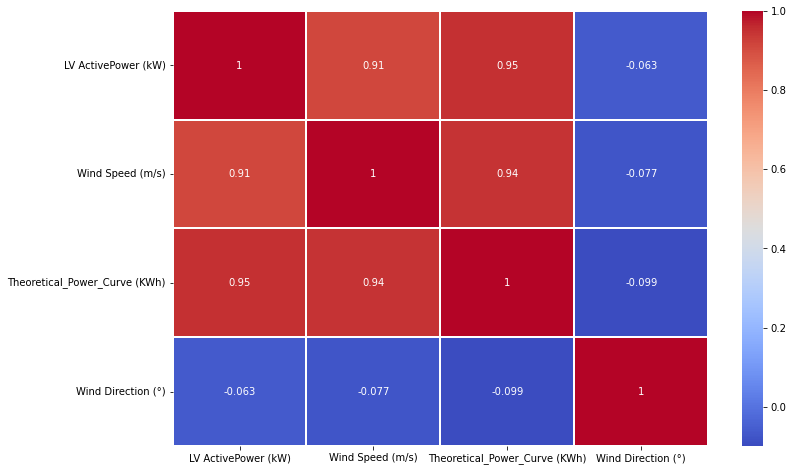

In [7]:
# using the seaborn heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=2)
plt.show()

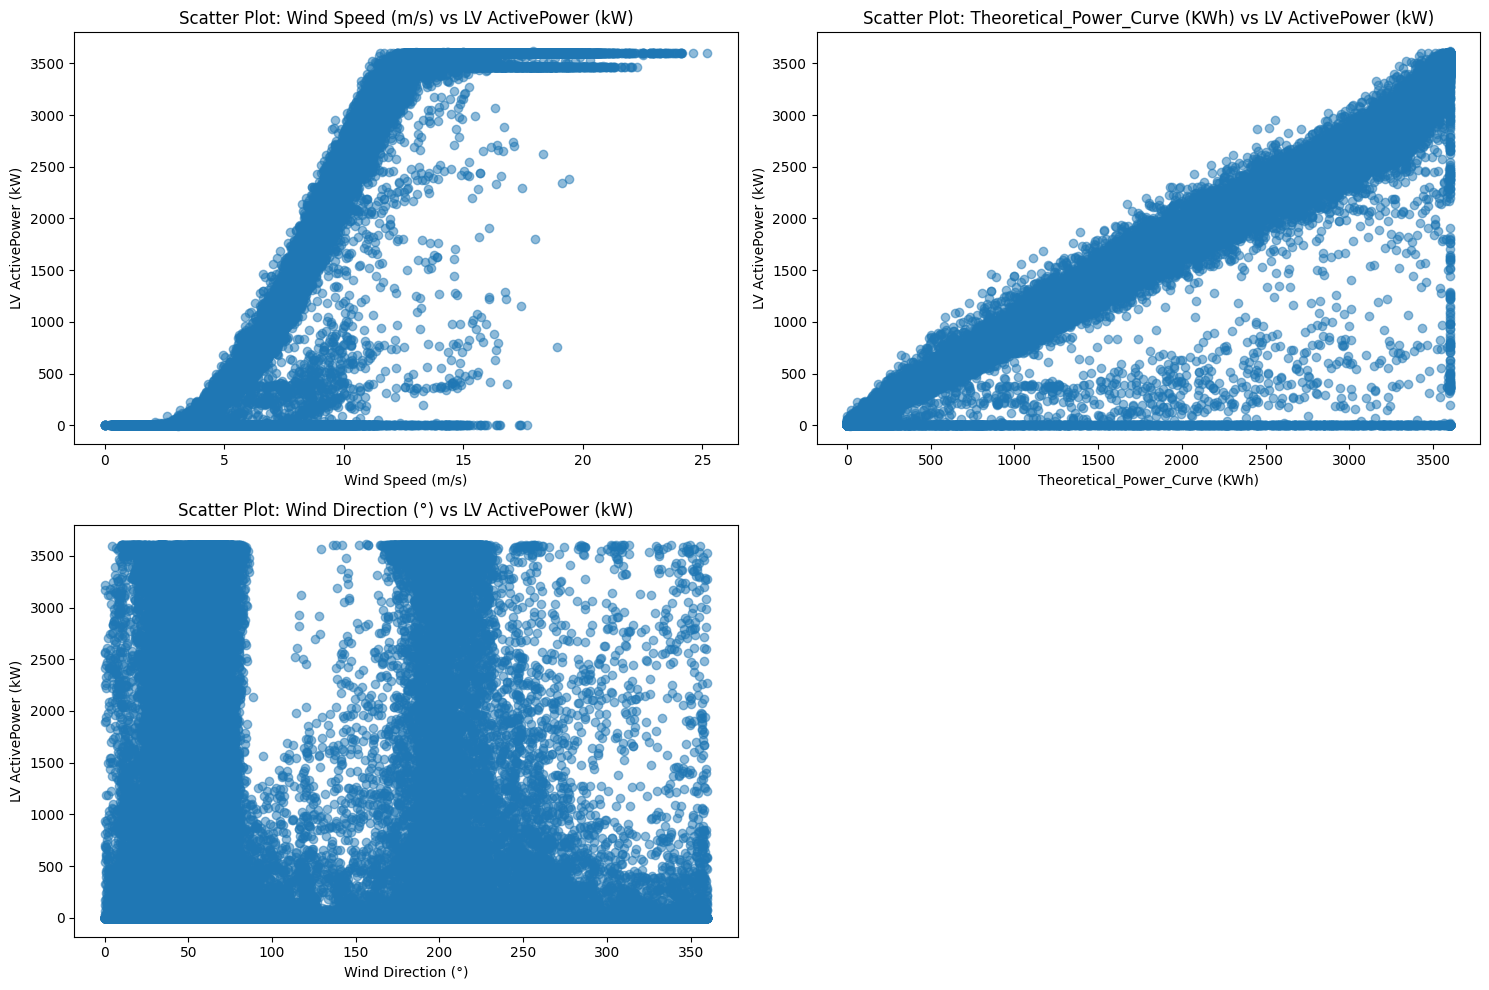

In [3]:
# using the scatter plot
target = 'LV ActivePower (kW)'
features = ['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']

#plots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)  
    plt.scatter(data[feature], data[target], alpha=0.5)
    plt.title(f'Scatter Plot: {feature} vs {target}')
    plt.xlabel(feature)
    plt.ylabel(target)

plt.tight_layout()
plt.show()

 Method for Forward and Backward Feature Selection

For Forward Feature Selection:

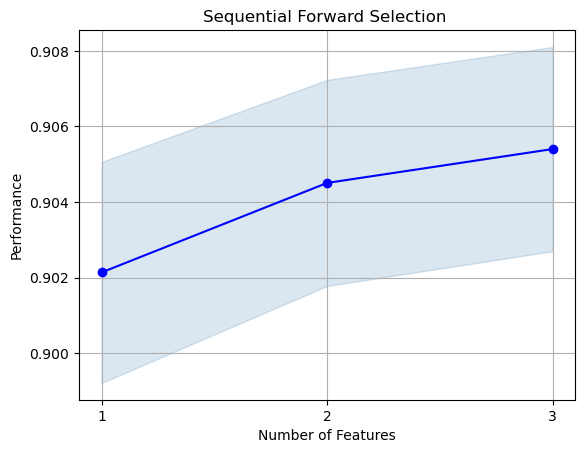

In [3]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = data.drop(['LV ActivePower (kW)', 'Date/Time'], axis=1)
y = data['LV ActivePower (kW)']

scaler =MinMaxScaler()
X = scaler.fit_transform(X)
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize linear regression model
lr = LinearRegression()

# Forward feature selection
sfs_forward = SFS(lr,
           k_features='best',
           forward=True,
           floating=False,
           scoring='r2',
           cv=5)

sfs_forward = sfs_forward.fit(X_train, y_train)

metric_dict = sfs_forward.get_metric_dict(confidence_interval=0.95)
fig1 = plot_sfs(metric_dict, kind='std_err')
plt.title('Sequential Forward Selection ')
plt.grid()
plt.show()

For Backward Feature Selection:

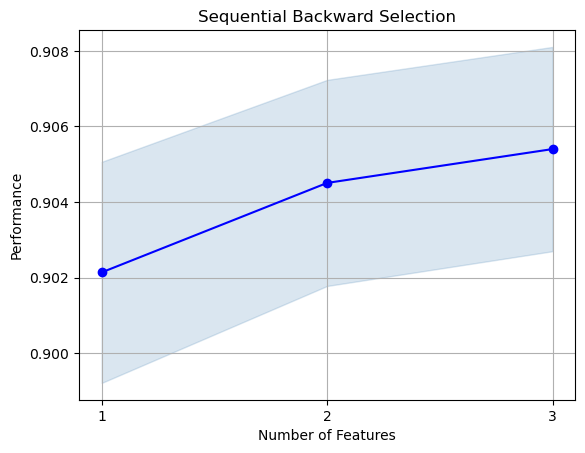

In [4]:
# Backward feature selection
sfs_backward = SFS(lr,
           k_features='best',
           forward=False,
           floating=False,
           scoring='r2',
           cv=5)

sfs_backward = sfs_backward.fit(X_train, y_train)

metric_dict_backward = sfs_backward.get_metric_dict(confidence_interval=0.95)
fig1 = plot_sfs(metric_dict_backward, kind='std_err')
plt.title('Sequential Backward Selection')
plt.grid()
plt.show()

 ## Section 3: Data Visualization

In [35]:
# Spliting the date time in year, month, days, hours and minutes
data['Year']= data['Date/Time'].apply(lambda x: time.strptime(x,"%d %m %Y %H:%M")[0])
data['Month']= data['Date/Time'].apply(lambda x: time.strptime(x,"%d %m %Y %H:%M")[1])
data['Day']= data['Date/Time'].apply(lambda x: time.strptime(x,"%d %m %Y %H:%M")[2])
data['Time_Hours']= data['Date/Time'].apply(lambda x: time.strptime(x,"%d %m %Y %H:%M")[3])
data['Time_Minutes']= data['Date/Time'].apply(lambda x: time.strptime(x,"%d %m %Y %H:%M")[4])
data.head(5)

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Year,Month,Day,Time_Hours,Time_Minutes
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904,2018,1,1,0,0
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113,2018,1,1,0,10
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789,2018,1,1,0,20
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087,2018,1,1,0,30
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286,2018,1,1,0,40


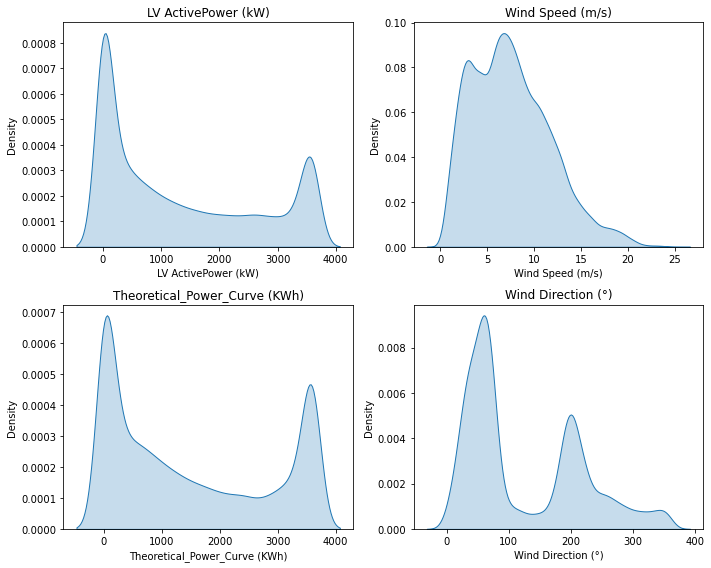

In [36]:
# plot the kde of the data
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(data.iloc[:,i+1], shade=True)
    plt.title(data.columns[i+1])
plt.tight_layout()
plt.show()

In [38]:
# convert a datetime to a timestamp
data['Date/Time'] = pd.to_datetime(data['Date/Time'], format='%d %m %Y %H:%M')
data


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Year,Month,Day,Time_Hours,Time_Minutes
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,2018,1,1,0,0
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,2018,1,1,0,10
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,2018,1,1,0,20
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,2018,1,1,0,30
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,2018,1,1,0,40
...,...,...,...,...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,2018,12,31,23,10
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,2018,12,31,23,20
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,2018,12,31,23,30
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,2018,12,31,23,40


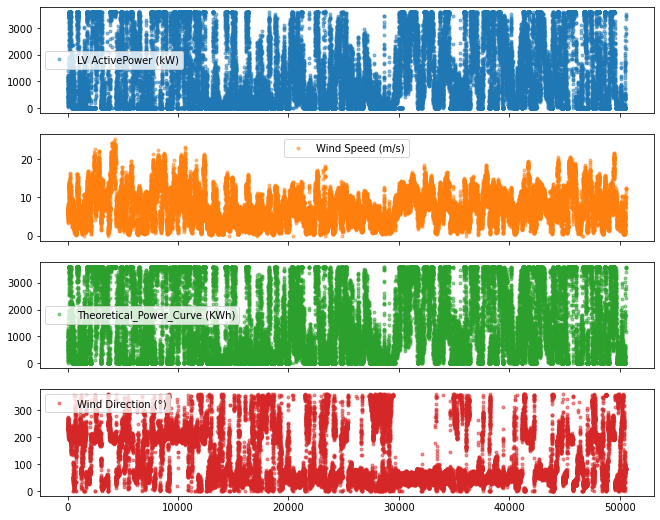

In [39]:
#plotting each data
cols_plot = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)','Wind Direction (°)']
axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

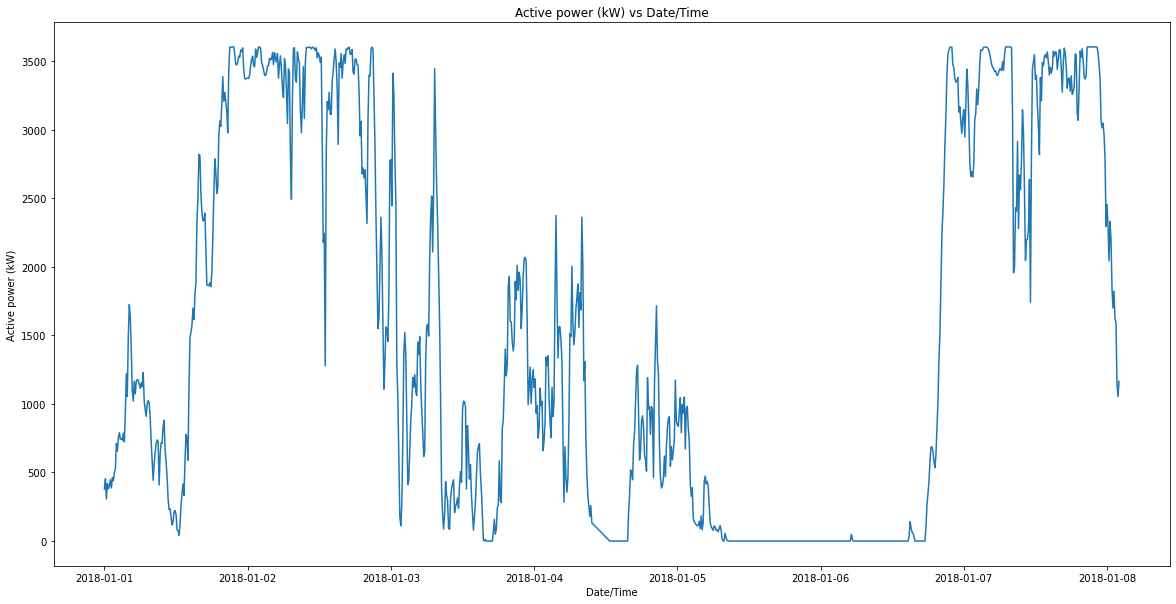

In [40]:
# line gaph of the datetime and activer power for the first 1000 data
plt.figure(figsize=(20, 10))
plt.plot(data['Date/Time'][:1000], data['LV ActivePower (kW)'][:1000])
plt.title('Active power (kW) vs Date/Time')
plt.xlabel('Date/Time')
plt.ylabel('Active power (kW)')
plt.show()

## Section 4: Preprocessing Data (Selecting the target, features, scaling, splitting)

In [41]:
# Droping all the irrelavent features that dosent affect the target variable.
cols = ['Year', 'Month', "Day", "Time_Hours", "Time_Minutes" ]
data = data.drop(cols, axis=1)
data.head()


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [42]:
# create a new dataframe from the prevous data
data_new = data.copy()
data_new = data_new.set_index('Date/Time')
data_new.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


((40424, 4), (10106, 4))

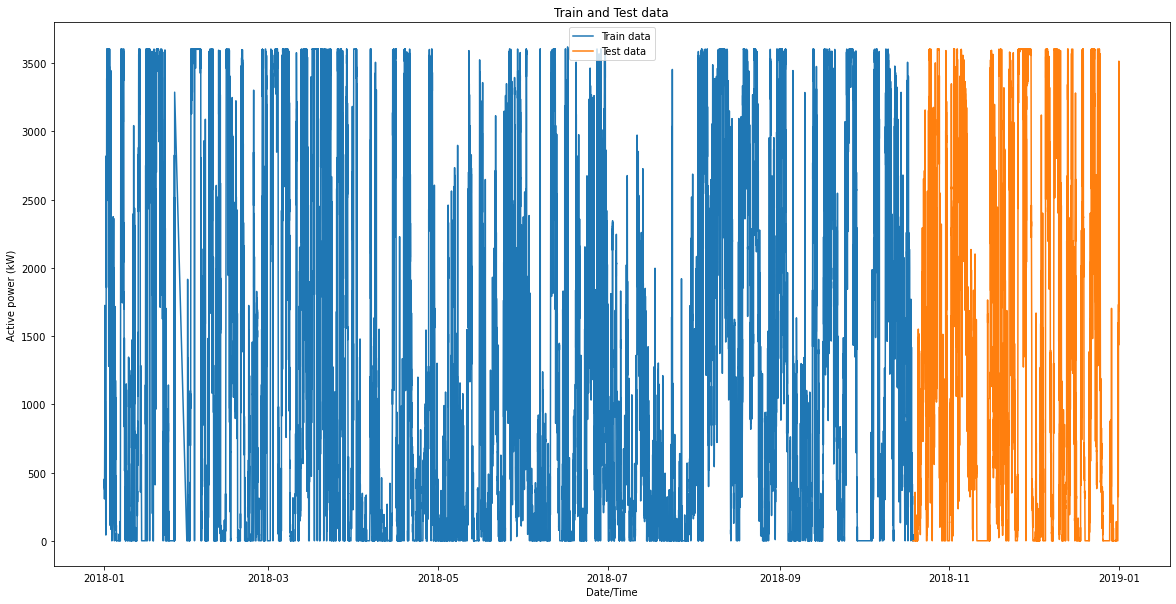

In [43]:
# split the data into training and testing data
train_size = int(len(data_new) * 0.80)
train_data, test_data = data_new.iloc[:train_size], data_new.iloc[train_size:]

#plot the train and test data
plt.figure(figsize=(20, 10))
plt.plot(train_data.index, train_data['LV ActivePower (kW)'], label='Train data')
plt.plot(test_data.index, test_data['LV ActivePower (kW)'], label='Test data')
plt.title('Train and Test data')
plt.xlabel('Date/Time')
plt.ylabel('Active power (kW)')
plt.legend()

# shape of the train and test data
train_data.shape, test_data.shape


In [44]:
# split the data into features and target variable
X_train = train_data.drop(['LV ActivePower (kW)','Wind Direction (°)'], axis=1)
y_train = train_data.loc[:, ['LV ActivePower (kW)']]
X_test = test_data.drop(['LV ActivePower (kW)','Wind Direction (°)'], axis=1)
y_test = test_data.loc[:,['LV ActivePower (kW)']]

# shape of the features and target variable
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((40424, 2), (40424, 1), (10106, 2), (10106, 1))

In [45]:
X_train.head()

,Wind Speed (m/s),Theoretical_Power_Curve (KWh)
Date/Time,,
2018-01-01 00:00:00,5.311336,416.328908
2018-01-01 00:10:00,5.672167,519.917511
2018-01-01 00:20:00,5.216037,390.900016
2018-01-01 00:30:00,5.659674,516.127569
2018-01-01 00:40:00,5.577941,491.702972


In [47]:
# Different scaler for input and output
scaler_x= MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
X_train_scaled = input_scaler.transform(X_train)
y_train_scaled = output_scaler.transform(y_train)

# Transform the test data
X_test_scaled = input_scaler.transform(X_test)
y_test_scaled = output_scaler.transform(y_test)

In [71]:
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 30
X_train, y_train = create_dataset(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test, y_test = create_dataset(X_test_scaled, y_test_scaled, TIME_STEPS)
# Print the shape of the sequences
print(f"X_seq train shape: {X_train.shape} | y_seq train shape : {y_train.shape}")
print(f"X_seq test shape: {X_test.shape} | y_seq test shape  : {y_test.shape}")

X_seq train shape: (40394, 30, 2) | y_seq train shape : (40394, 1)
X_seq test shape: (10076, 30, 2) | y_seq test shape  : (10076, 1)


### Step 3: Building the models and Training them

## Section 1: building the model

In [72]:
def create_model(units, layer_type):
    model = Sequential()
    
    model.add(layer_type(units=units, dropout=0.05, return_sequences=True,
                         input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    
    model.add(layer_type(units=units, dropout=0.2))
    
    model.add(Dense(units=1))
    
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer)
    return model

def create_cnn(layer_type):
    model = Sequential()
    
    model.add(layer_type(filters=64, kernel_size=3, 
                         input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    
    model.add(layer_type(filters=64, kernel_size=3))
   
    model.add(Dense(units=1))
    
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer)
    return model

# models
model_gru = create_model(32, GRU)
model_lstm = create_model(32, LSTM)
model_conv1d = create_cnn(Conv1D)
model_rnn = create_model(32, SimpleRNN)

/home/abdulrahman.almansoo/.conda/envs/bigdataproject/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/abdulrahman.almansoo/.conda/envs/bigdataproject/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [73]:
# Fit models
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7)

    
    history = model.fit(X_train, y_train, epochs = 30, validation_split = 0.2,
                    batch_size = 64, shuffle = False, callbacks = [early_stop])
    return history

## Section 2: Training the models

In [74]:
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)
history_conv1d = fit_model(model_conv1d)
history_rnn = fit_model(model_rnn)

Epoch 1/30


505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0885 - val_loss: 0.0246
Epoch 2/30
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0601 - val_loss: 0.0213
Epoch 3/30
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0510 - val_loss: 0.0138
Epoch 4/30
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0467 - val_loss: 0.0107
Epoch 5/30
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0446 - val_loss: 0.0102
Epoch 6/30
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0426 - val_loss: 0.0088
Epoch 7/30
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0413 - val_loss: 0.0085
Epoch 8/30
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0396 - val_loss: 0.0083
Epoch 9/30
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0389 - val_loss: 0.0080
Epoch 10/30
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0388 - val_loss: 0.0077
Epoch 11/30
505/505 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0378 - val_loss: 0.0075
Epoch 12/30
505/505 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/ste

## Section 3: Viuslization of train and validation loss

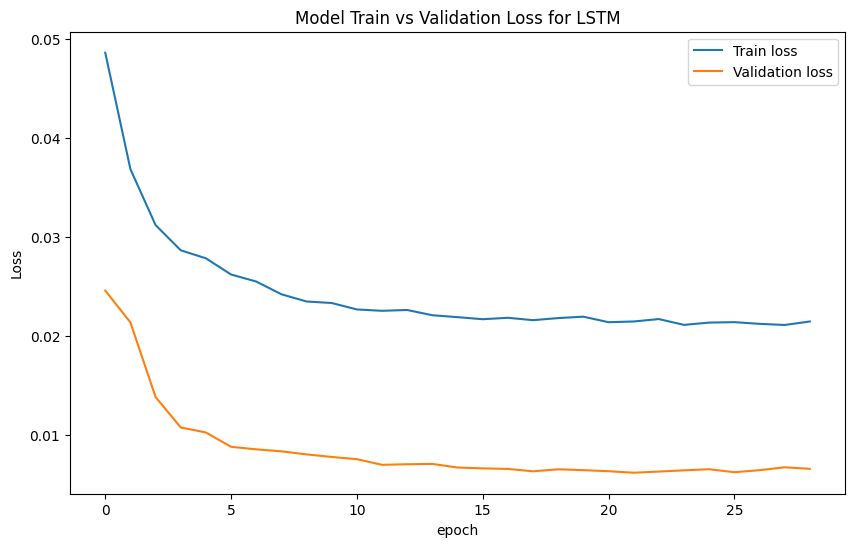

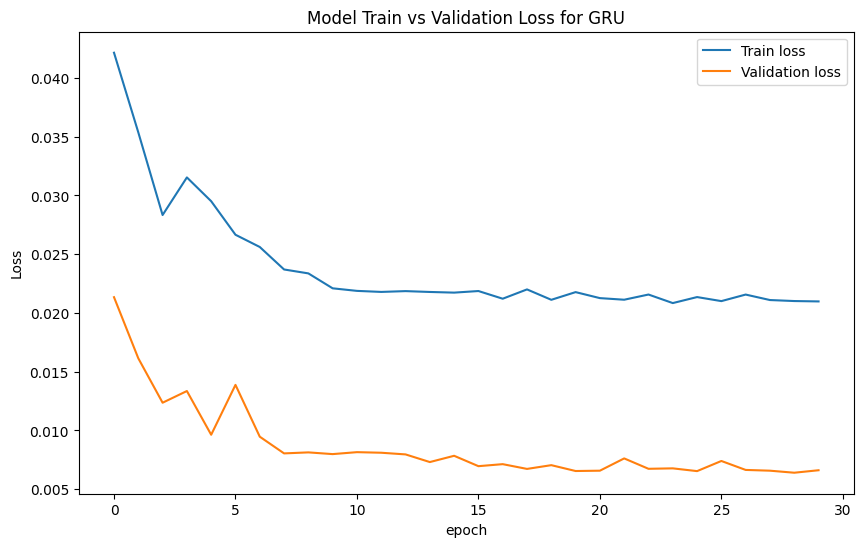

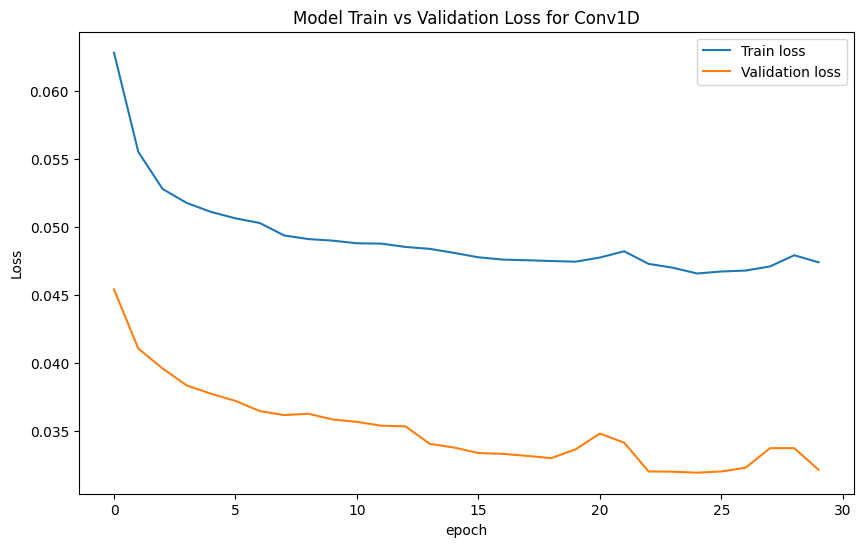

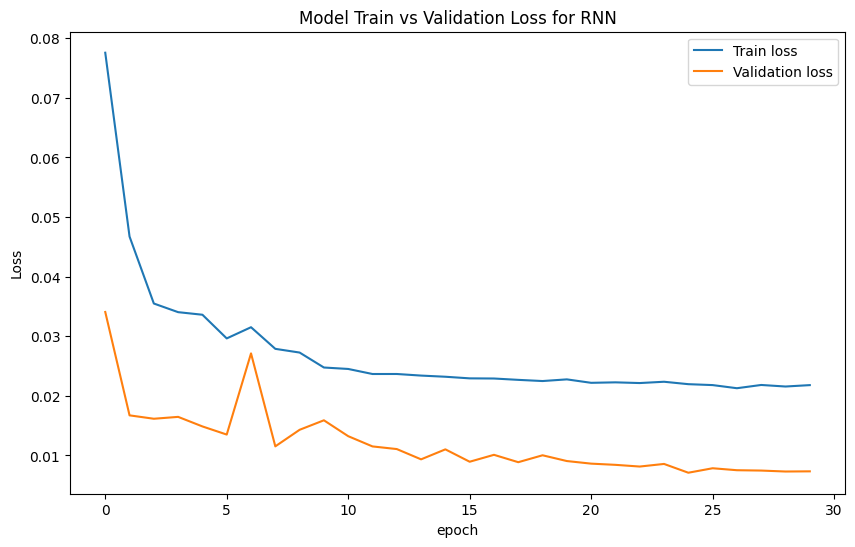

In [75]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.show()

# Plot loss
plot_loss (history_lstm, 'LSTM')
plot_loss (history_gru, 'GRU')
plot_loss (history_conv1d, 'Conv1D')
plot_loss (history_rnn, 'RNN')

### Step 4: Evaluation and Visulization

In [49]:
# Note that we have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [77]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

def prediction_cnn(model):
    prediction = model.predict(X_test)
    prediction = prediction[:, -1, :]
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)
prediction_conv1d = prediction_cnn(model_conv1d)
prediction_rnn = prediction(model_rnn)

315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [78]:
# Create a DataFrame for the actual and predicted values
comparison_df = pd.DataFrame({
    'Actual': y_test.flatten(),  
    'LSTM_Prediction': prediction_lstm.flatten(),  
    'GRU_Prediction': prediction_gru.flatten(),
    'Conv1d_Prediction': prediction_conv1d.flatten(),  
    'RNN_Prediction': prediction_rnn.flatten() 
})

# Display the first 10 elements of the DataFrame
comparison_df.head(10)

,Actual,LSTM_Prediction,GRU_Prediction,Conv1d_Prediction,RNN_Prediction
0,0.0,195.087769,129.978210,-62.583061,126.545265
1,0.0,206.743286,126.877876,-43.942425,98.180359
2,0.0,206.114090,110.355598,-56.648472,80.743889
3,0.0,208.182404,122.869934,-68.820534,98.583221
4,0.0,214.555786,132.048019,-43.175163,107.944878
5,0.0,212.543518,117.995552,-45.865833,88.630272
6,0.0,215.218704,124.218933,-38.546623,102.374352
7,0.0,218.783691,124.501579,3.806265,85.545479
8,0.0,209.866180,107.742416,13.550820,59.558918
9,0.0,201.911835,113.156021,12.994598,65.288193


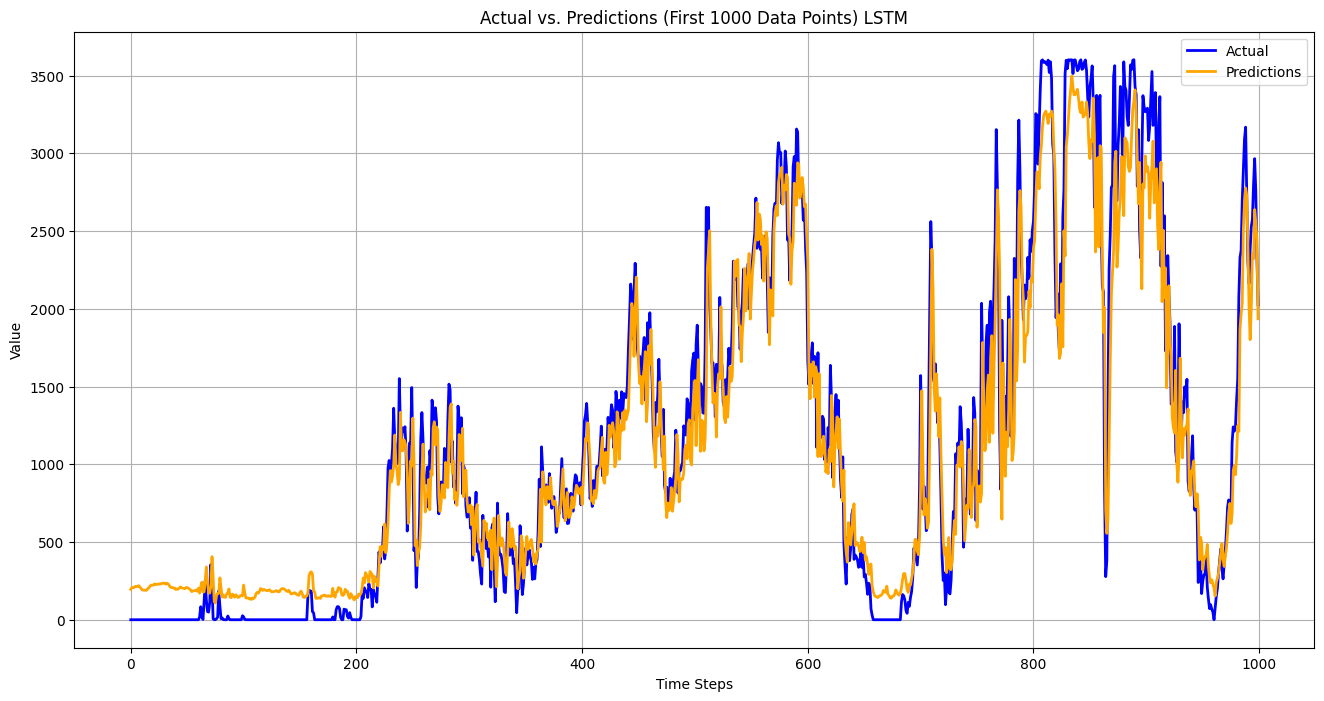

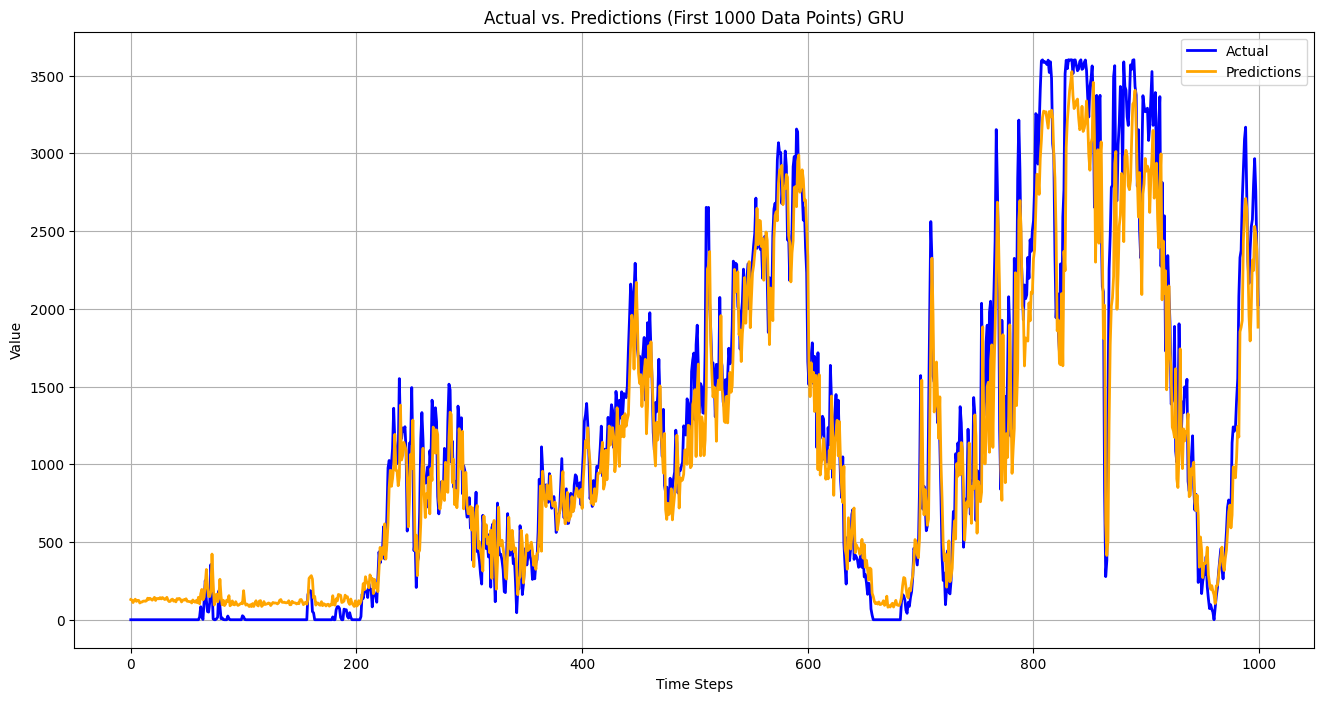

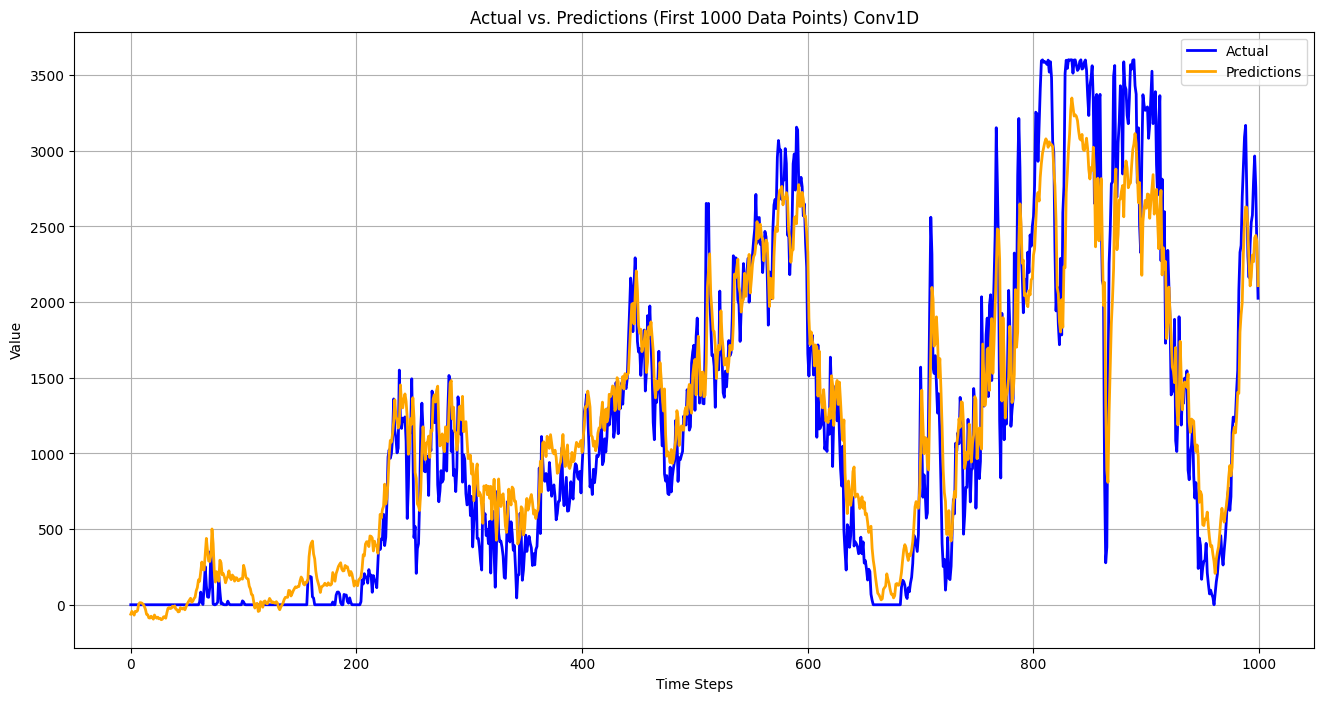

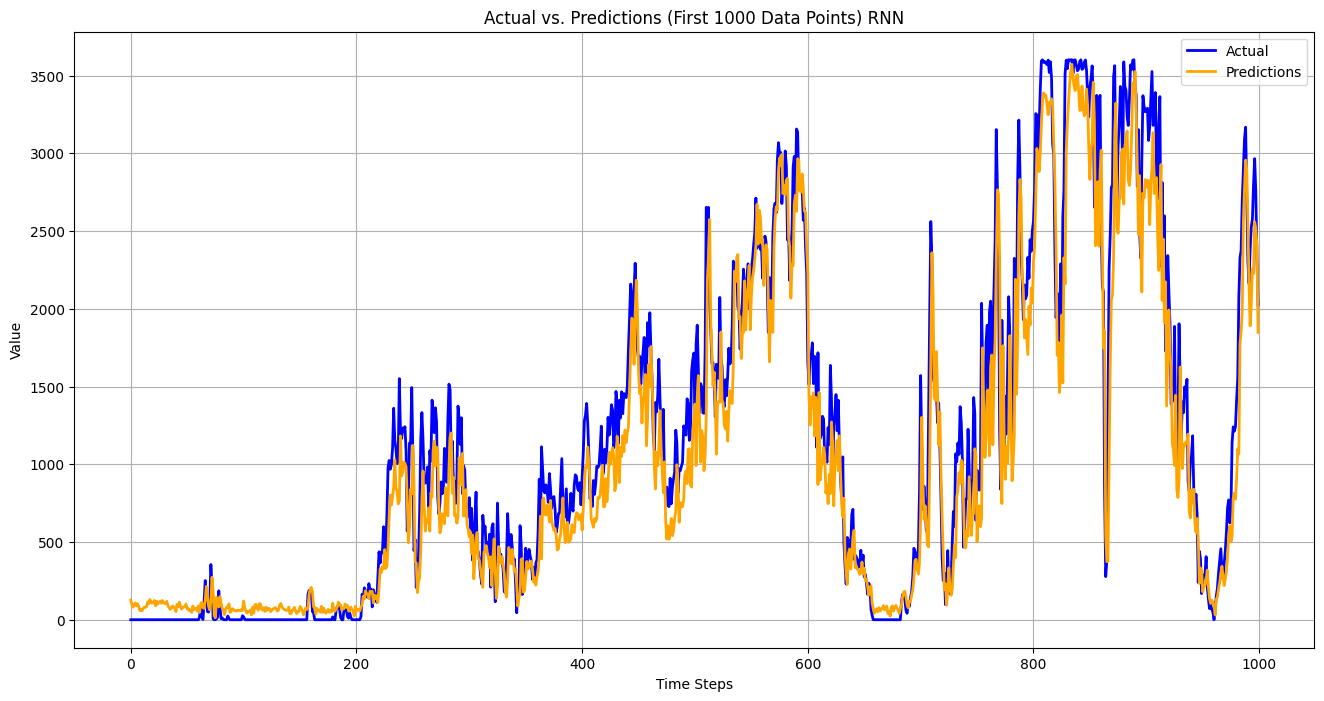

In [79]:
def plot_predictions_comparison(actual, prediction, model_name, num_points=1000):
    plt.figure(figsize=(16, 8))  # Increased figure size for better visibility

    # Select the first 1000 elements for plotting
    actual_plot = y_test[:num_points]
    prediction_plot = prediction[:num_points]

    # Create the plot
    plt.plot(actual_plot, label='Actual', color='blue', linewidth=2)
    plt.plot(prediction_plot, label='Predictions', color='orange', linewidth=2)

    plt.title('Actual vs. Predictions (First 1000 Data Points) ' + model_name)
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()



# Plot the first 1000 actual and predicted values
plot_predictions_comparison(y_test, prediction_lstm, 'LSTM')
plot_predictions_comparison(y_test, prediction_gru, 'GRU')
plot_predictions_comparison(y_test, prediction_conv1d, 'Conv1D')
plot_predictions_comparison(y_test, prediction_rnn, 'RNN')

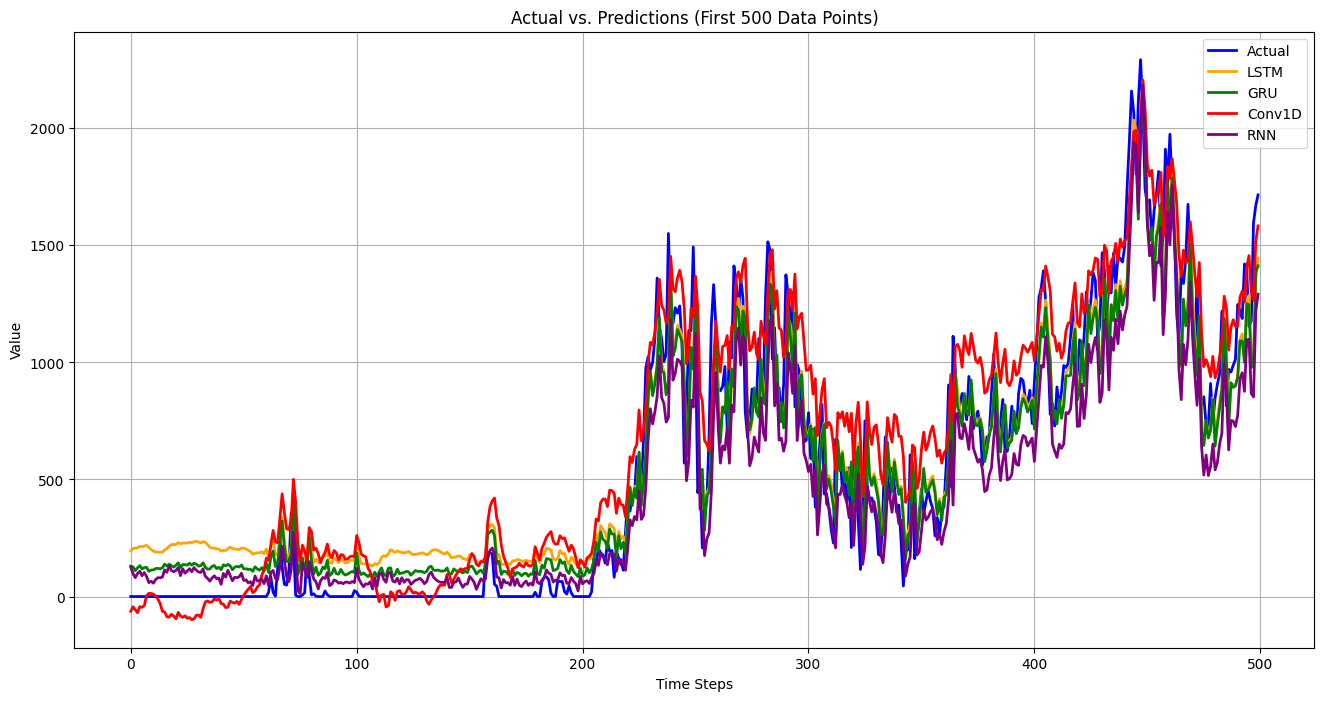

In [80]:
# plot all the models and the actual data for the first 500 data
plt.figure(figsize=(16, 8))
plt.plot(y_test[:500], label='Actual', color='blue', linewidth=2)
plt.plot(prediction_lstm[:500], label='LSTM', color='orange', linewidth=2)
plt.plot(prediction_gru[:500], label='GRU', color='green', linewidth=2)
plt.plot(prediction_conv1d[:500], label='Conv1D', color='red', linewidth=2)
plt.plot(prediction_rnn[:500], label='RNN', color='purple', linewidth=2)
plt.title('Actual vs. Predictions (First 500 Data Points)')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [81]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mae = mean_absolute_error(actual, predictions)
    r2 = r2_score(actual, predictions)

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('R^2 Score: {:.4f}'.format(r2))
    print('')


evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_conv1d, y_test, 'Conv1D')
evaluate_prediction(prediction_rnn, y_test, 'RNN')

LSTM:
Mean Absolute Error: 298.3344
Root Mean Square Error: 470.8591
R^2 Score: 0.8768

GRU:
Mean Absolute Error: 288.9971
Root Mean Square Error: 467.9628
R^2 Score: 0.8783

Conv1D:
Mean Absolute Error: 349.3382
Root Mean Square Error: 508.3122
R^2 Score: 0.8565

RNN:
Mean Absolute Error: 293.5955
Root Mean Square Error: 475.8048
R^2 Score: 0.8742



### Gaussian Process Method

/home/abdulrahman.almansoo/.conda/envs/bigdataproject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/abdulrahman.almansoo/.conda/envs/bigdataproject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/abdulrahman.almansoo/.conda/envs/bigdataproject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit ag

Mean Absolute Error: 192.396
Root Mean Square Error: 412.051
R^2 Score: 0.900


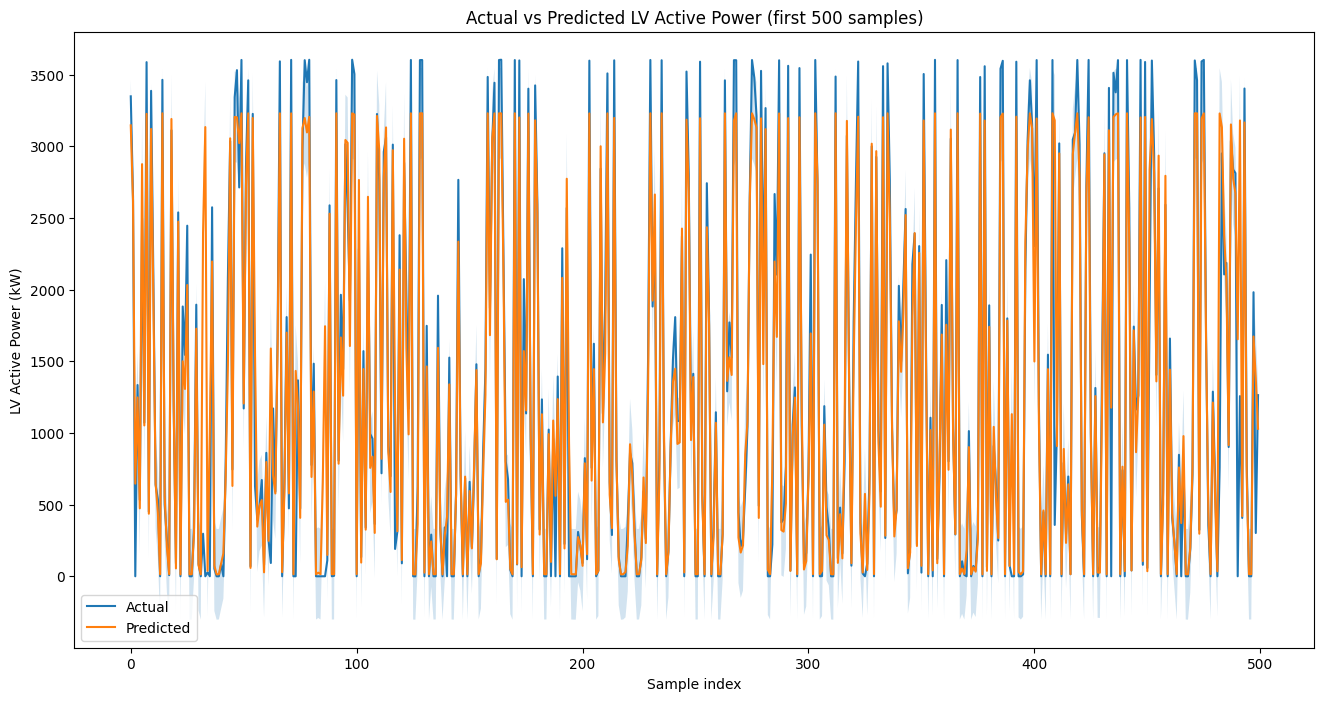

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.gaussian_process import kernels
from sklearn.gaussian_process.kernels import WhiteKernel

# Assuming X and y are your data loaded here
X = data[['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']].values
y = data['LV ActivePower (kW)'].values
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the kernel: a product of constant kernel and RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) + WhiteKernel(noise_level=1)

# Create Gaussian process model with Approximate GP using subset of data
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1, random_state=42)

# Use only a subset of data for the inducing points
inducing_point_indices = np.random.choice(X_train.shape[0], 15000, replace=False)
X_inducing = X_train[inducing_point_indices]
y_inducing = y_train[inducing_point_indices]

model.fit(X_inducing, y_inducing)

# Make predictions
y_pred, y_std = model.predict(X_test, return_std=True)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print performance metrics
print(f'Mean Absolute Error: {mae:.3f}')
print(f'Root Mean Square Error: {rmse:.3f}')
print(f'R^2 Score: {r2:.3f}')

# Plot actual vs predicted for the first 500 points
plt.figure(figsize=(16, 8))
plt.plot(np.arange(500), y_test[:500], label='Actual')
plt.plot(np.arange(500), y_pred[:500], label='Predicted')
plt.fill_between(np.arange(500), y_pred[:500] - y_std[:500], y_pred[:500] + y_std[:500], alpha=0.2)
plt.title('Actual vs Predicted LV Active Power (first 500 samples)')
plt.xlabel('Sample index')
plt.ylabel('LV Active Power (kW)')
plt.legend()
plt.show()

### Linear Regression Method 

Mean Absolute Error: 188.752
Root Mean Square Error: 411.710
R^2 Score: 0.901


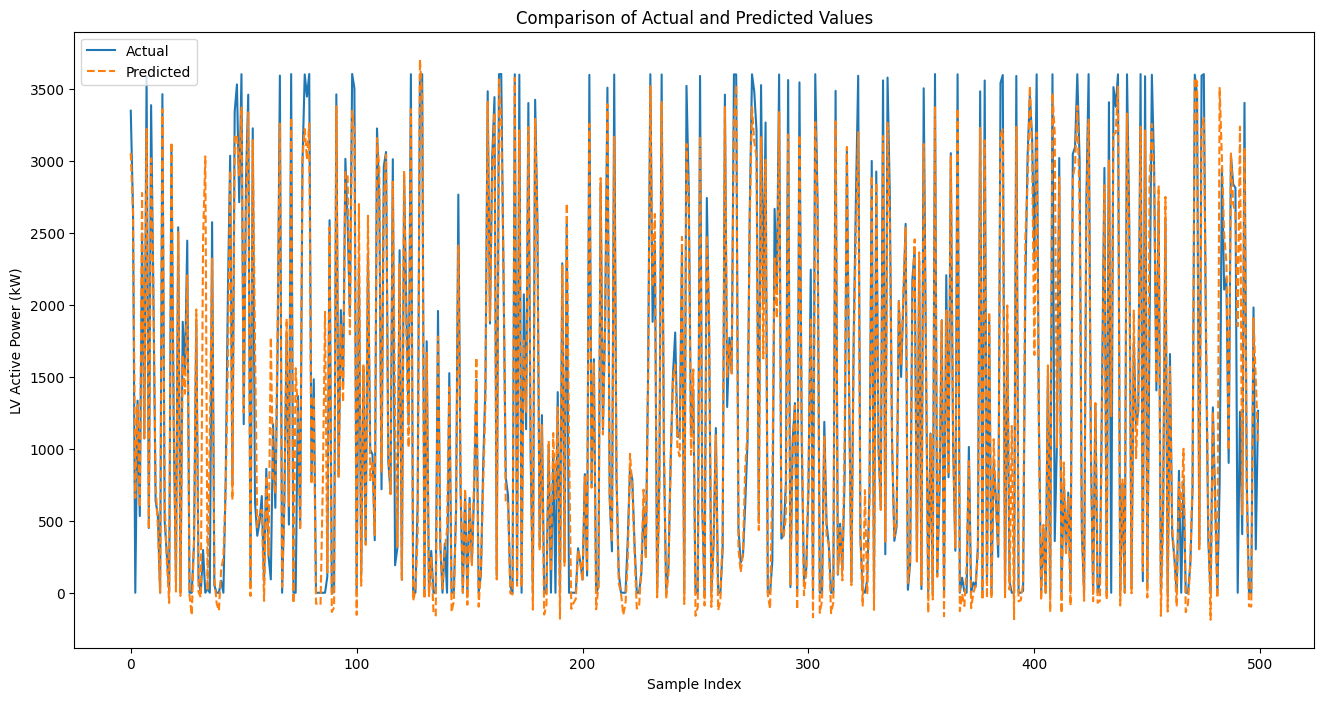

In [13]:
from sklearn.model_selection import train_test_split
# Select features and target
X = data[['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']]
y = data['LV ActivePower (kW)']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print performance metrics
print(f'Mean Absolute Error: {mae:.3f}')
print(f'Root Mean Square Error: {rmse:.3f}')
print(f'R^2 Score: {r2:.3f}')

# Plotting the first 500 actual vs predicted values
plt.figure(figsize=(16, 8))
plt.plot(y_test[:500].reset_index(drop=True), label='Actual')
plt.plot(y_pred[:500], label='Predicted', linestyle='--')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('LV Active Power (kW)')
plt.legend()
plt.show()
